In [35]:
import pandas as pd
import gensim
import numpy as np
from sklearn.model_selection import KFold
import nltk
from nltk.corpus import stopwords
# Import textblob
from textblob import Word, TextBlob
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict
import warnings
warnings.filterwarnings("ignore")

# low_fat

## Data Preprocessing

In [18]:
df = pd.read_excel('Meals_w_Goals_deid_snapshot.xlsx', 'low_fat_1')

In [19]:
df['meal_ingredients'].isnull().sum()

0

In [20]:
df = df.dropna(axis=0, subset=['meal_ingredients'])

In [21]:
df['meal_ingredients'].isnull().sum()

0

In [22]:
df['meal_ingredients'] = df['meal_ingredients'].astype(str)

In [23]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yashjain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yashjain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
def preprocess_meals(meal):
    processed_meal = meal
    processed_meal.replace('[^\w\s]', '')
    processed_meal = " ".join(word for word in processed_meal.split() if word not in stop_words)
    #processed_meal = " ".join(word for word in processed_meal.split() if word not in custom_stopwords)
    processed_meal = " ".join(Word(word).lemmatize() for word in processed_meal.split())
    return(processed_meal)

In [25]:
from sklearn.preprocessing import OrdinalEncoder
label = df['expert_assessment']
enc = OrdinalEncoder(categories = [['not_really', 'yes']])
df['expert_assessment'] = enc.fit_transform(label.to_numpy().reshape(-1,1))

In [26]:
total = df['expert_assessment'].count()
negative = df['expert_assessment'][df['expert_assessment']==0].count()
positive = df['expert_assessment'][df['expert_assessment']==1].count()
print('Total observations:', total)
print('Total negative labels:', negative)
print('Total positive labels:', positive)

Total observations: 410
Total negative labels: 202
Total positive labels: 208


# TFIDF


## Meal Ingredients

In [27]:
df['meal_ingredients'] = df['meal_ingredients'].apply(lambda x: preprocess_meals(x))

In [28]:
df['meal_ingredients']

0             Mince meat 1/4 burger broccoli bean sprout
1      Slice Sausage quiche, mixed salad: lettuce, to...
2      Liverwurst/Gouda cheese sandwich lettuce tomat...
3                                           Chicken wing
4      Salami/Swiss cheese wheat bread, trail mix: ca...
                             ...                        
405                                     Egg white pepper
406    1/2 cup oatmeal, 2x hard-boiled egg cup black ...
407    Yellow rice, black beans, mixed salad: lettuce...
408    Cup cashews, cup trail mix banana 23 oz bottle...
409    Jamaican vegetable pattie wheat 16 oz bottle w...
Name: meal_ingredients, Length: 410, dtype: object

In [29]:
document = []
for i in df['meal_ingredients']:
    if i != '':
        document.append(i)

In [30]:
document

['Mince meat 1/4 burger broccoli bean sprout',
 'Slice Sausage quiche, mixed salad: lettuce, tomato, cucumber, strawberry carrots. 16 oz bottle water.',
 'Liverwurst/Gouda cheese sandwich lettuce tomato mustard on12 grain bread. 12 oz cup black coffee 1 x tspn raw sugar.',
 'Chicken wing',
 'Salami/Swiss cheese wheat bread, trail mix: cashews, almonds, raisins, papaya video pineapple pieces. 12 oz cup black coffee 2 x tspn raw sugar.',
 'Chicken Bolognese , mashed potato peas. Cup black coffee 2 tspn raw sugar.',
 'Yellow rice red beans, steak onion 16 oz bottle water.',
 'Test',
 'White rice,corned beef,potatoes chopped platanoes frito.',
 'Pork sausage Gravy buttermilk biscuit.',
 'Pumpkin',
 'Mince meat cabbage',
 'Spanish / rice bean salad beef ox tail',
 'Baked ziti, lettuce/tomato salad tangerine. 30 oz bottle water.',
 'Beef pot pie',
 'Filled beef vegetable pot pie',
 'Spinach quish 12 oz cup black coffee 2 x tspn sugar',
 'Lunch waters.',
 'Fried chicken breast, string beans, 

In [31]:
data_X = np.squeeze(pd.DataFrame(df['meal_ingredients']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [33]:
print(X_train.shape, X_test.shape)

(328,) (82,)


In [36]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['meal_ingredients']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))


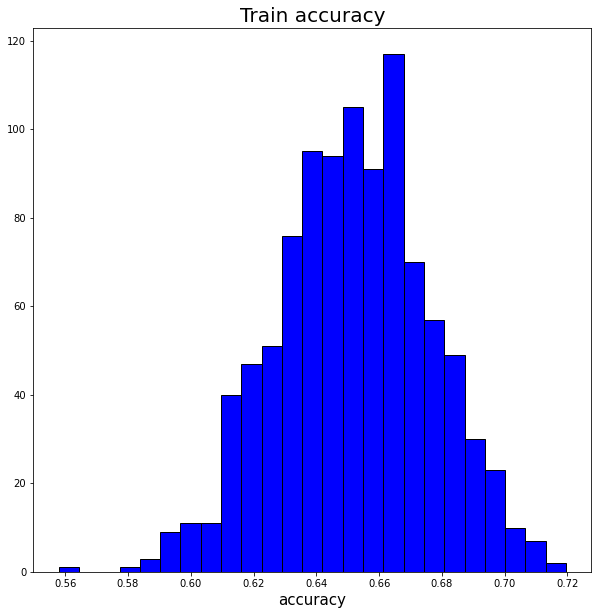

In [37]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [38]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.6517774390243903
0.024321914768336308


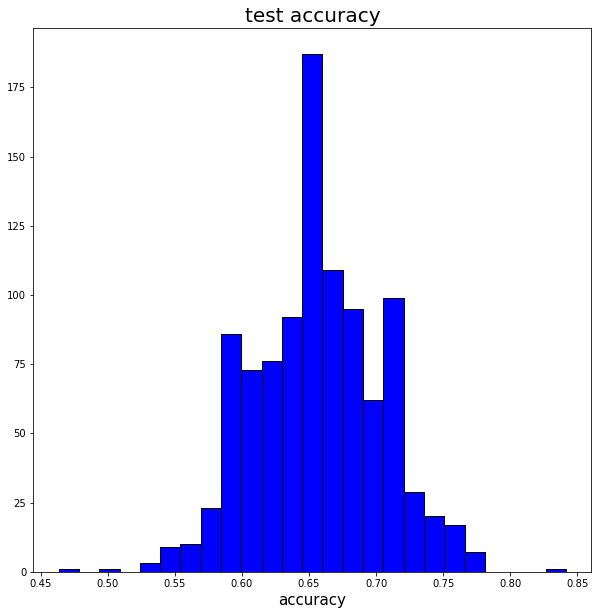

In [39]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [40]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.6565
0.047198605467960245


# TFIDF Meal Title

In [41]:
df['meal_title'].isnull().sum()

0

In [42]:
df['meal_title'] = df['meal_title'].astype(str)

In [43]:
df = df.dropna(axis=0, subset=['meal_title'])

In [44]:
df['meal_title'].isnull().sum()

0

In [45]:
document = []
for i in df['meal_title']:
    if i != '':
        document.append(i)

In [46]:
data_X = np.squeeze(pd.DataFrame(df['meal_title']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [47]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [48]:
print(X_train.shape, X_test.shape)

(328,) (82,)


In [49]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['meal_title']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

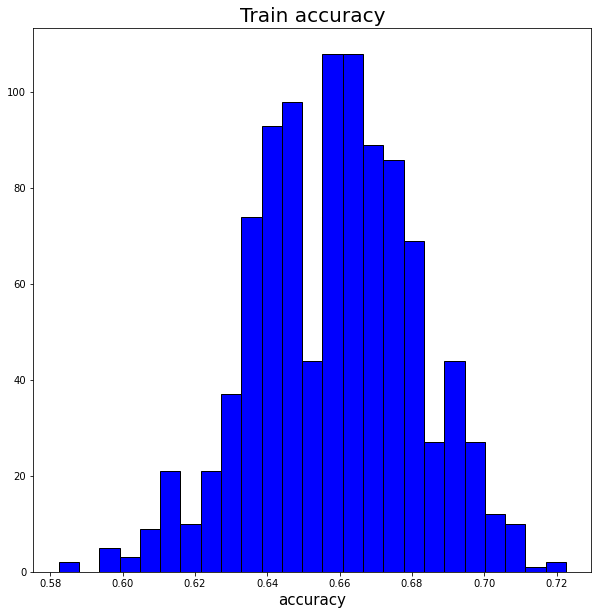

In [50]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [51]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.6584481707317074
0.022057702225498663


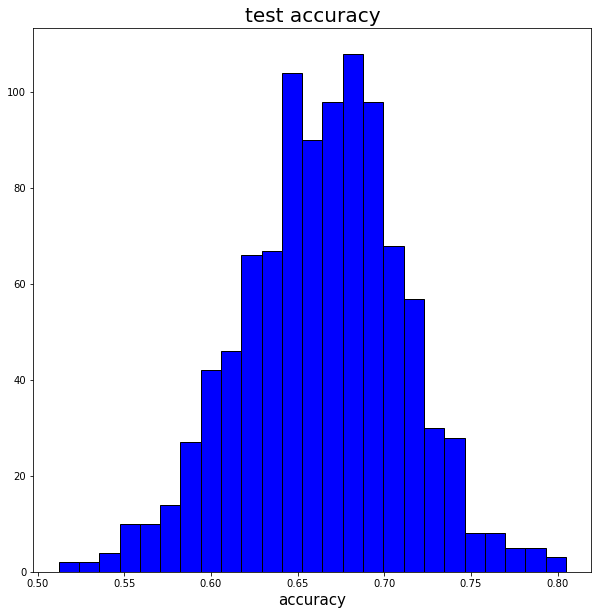

In [52]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [53]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.6642926829268292
0.04823046003752495


# TFIDF Ingredients + Title

In [54]:
df['ingredients_and_title'] = df['meal_ingredients'].astype(str) +' '+ df['meal_title'].astype(str)

In [55]:
document = []
for i in df['ingredients_and_title']:
    if i != '':
        document.append(i)

In [56]:
document

['Mince meat 1/4 burger broccoli bean sprout Dinner',
 'Slice Sausage quiche, mixed salad: lettuce, tomato, cucumber, strawberry carrots. 16 oz bottle water. Sausage quiche, mixed salad and bottle of water.',
 'Liverwurst/Gouda cheese sandwich lettuce tomato mustard on12 grain bread. 12 oz cup black coffee 1 x tspn raw sugar. Liverwurst/Gouda cheese sandwich w/lettuce, tomato and mustard on 12 grain bread.',
 'Chicken wing Wings',
 'Salami/Swiss cheese wheat bread, trail mix: cashews, almonds, raisins, papaya video pineapple pieces. 12 oz cup black coffee 2 x tspn raw sugar. Salami/Swiss on wheat bread. Trail Mix and black coffee.',
 'Chicken Bolognese , mashed potato peas. Cup black coffee 2 tspn raw sugar. Chicken Italians, mashed potatoes, peas and coffee.',
 'Yellow rice red beans, steak onion 16 oz bottle water. Yellow rice and red beans. Steak with onions. Bottle of water.',
 'Test Test',
 'White rice,corned beef,potatoes chopped platanoes frito. Corned beef meal,rice',
 'Pork sa

In [57]:
data_X = np.squeeze(pd.DataFrame(df['ingredients_and_title']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [58]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [59]:
print(X_train.shape, X_test.shape)

(328,) (82,)


In [60]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['ingredients_and_title']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))


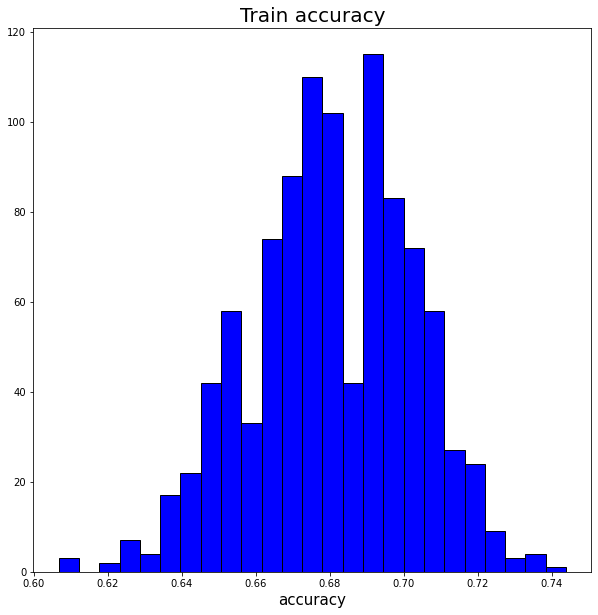

In [61]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [62]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.6801310975609756
0.021875315711157604


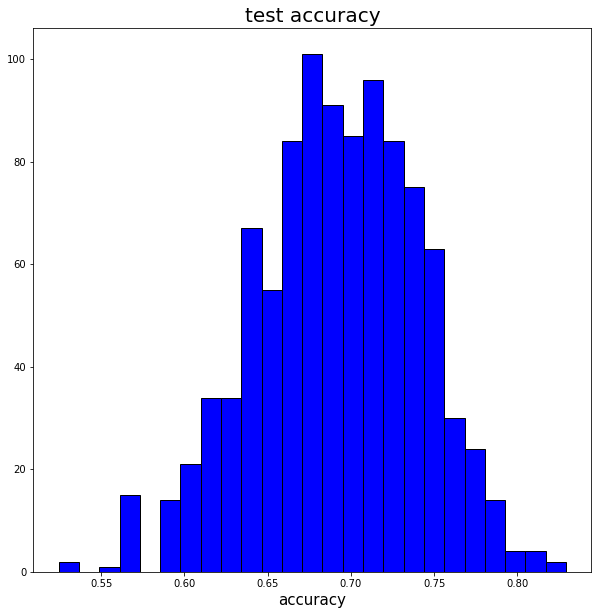

In [63]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [64]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.6852926829268292
0.04850281335174185


# Word2vec

## ingredients

In [65]:
df['meal_ingredients'] = df['meal_ingredients'].apply(lambda x: preprocess_meals(x))

In [66]:
meal_ingredients = df.meal_ingredients.apply(gensim.utils.simple_preprocess)

In [67]:
meal_ingredients

0          [mince, meat, burger, broccoli, bean, sprout]
1      [slice, sausage, quiche, mixed, salad, lettuce...
2      [liverwurst, gouda, cheese, sandwich, lettuce,...
3                                        [chicken, wing]
4      [salami, swiss, cheese, wheat, bread, trail, m...
                             ...                        
405                                 [egg, white, pepper]
406    [cup, oatmeal, hard, boiled, egg, cup, black, ...
407    [yellow, rice, black, beans, mixed, salad, let...
408    [cup, cashews, cup, trail, mix, banana, oz, bo...
409    [jamaican, vegetable, pattie, wheat, oz, bottl...
Name: meal_ingredients, Length: 410, dtype: object

In [68]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_ingredients, progress_per = 100)

embeddings.train(meal_ingredients, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_ingredients = embeddings.wv.index_to_key

In [69]:
learned_words_meal_ingredients

['water',
 'oz',
 'bottle',
 'chicken',
 'rice',
 'black',
 'coffee',
 'cheese',
 'pepper',
 'egg',
 'tomato',
 'dash',
 'garlic',
 'milk',
 'salad',
 'bread',
 'lettuce',
 'powder',
 'sugar',
 'cup',
 'mrs',
 'white',
 'onion',
 'sweeter',
 'red',
 'soup',
 'cinnamon',
 'bean',
 'banana',
 'tsp',
 'parsley',
 'beef',
 'mayonnaise',
 'tspn',
 'sandwich',
 'little',
 'pork',
 'mixed',
 'cracker',
 'green',
 'ham',
 'boiled',
 'oatmeal',
 'bit',
 'sausage',
 'corn',
 'vegetable',
 'hard',
 'wheat',
 'packs',
 'slice',
 'raw',
 'eggs',
 'noodle',
 'beans',
 'yellow',
 'sauce',
 'meat',
 'cilantro',
 'cucumber',
 'strawberry',
 'carrots',
 'orange',
 'roll',
 'fish',
 'pack',
 'none',
 'onions',
 'spaghetti',
 'cornflakes',
 'juice',
 'breast',
 'broccoli',
 'potato',
 'carrot',
 'steak',
 'ms',
 'tea',
 'cabbage',
 'fried',
 'toast',
 'spinach',
 'fry',
 'peppers',
 'sugars',
 'noodles',
 'pam',
 'put',
 'lightly',
 'smeared',
 'french',
 'yugort',
 'roast',
 'spice',
 'bakery',
 'bacon',

In [70]:
words = []
for i in meal_ingredients:
    temp = []
    for j in i:
        if j in learned_words_meal_ingredients:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [71]:
l = []
eg = 0
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [72]:
data_y = np.squeeze(data_y)
data_y.shape

(410,)

In [73]:
data_X = pd.DataFrame(l)
data_X.shape

(410, 100)

In [74]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

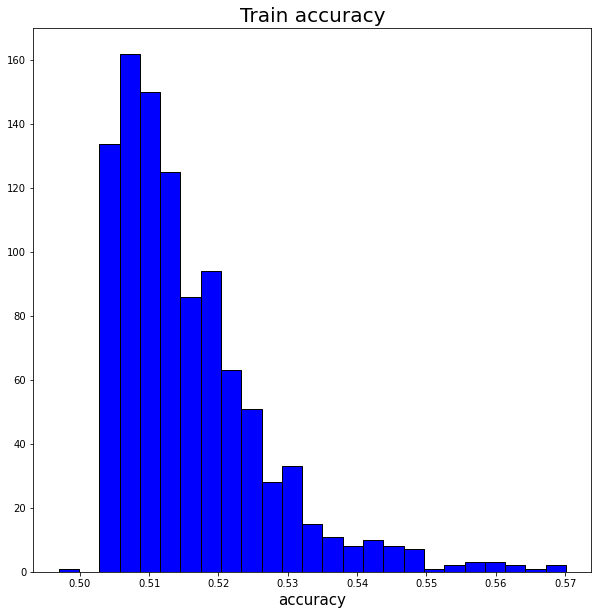

In [75]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [76]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.5148932926829268
0.011272152078360726


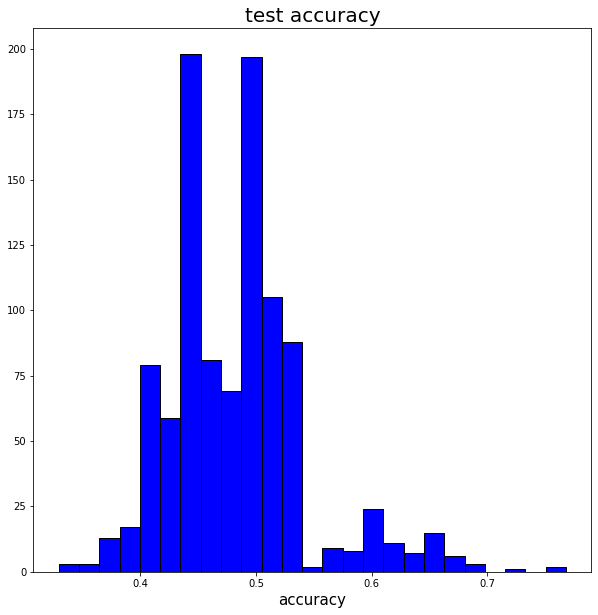

In [77]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [78]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.482
0.05888289833929048


## title

In [79]:
df['meal_title'].isnull().sum()

0

In [80]:
df['meal_title'] = df['meal_title'].astype(str)

In [81]:
df = df.dropna(axis=0, subset=['meal_title'])

In [82]:
df['meal_title'].isnull().sum()

0

In [83]:
meal_title = df.meal_title.apply(gensim.utils.simple_preprocess)

In [84]:
meal_title

0                                               [dinner]
1      [sausage, quiche, mixed, salad, and, bottle, o...
2      [liverwurst, gouda, cheese, sandwich, lettuce,...
3                                                [wings]
4      [salami, swiss, on, wheat, bread, trail, mix, ...
                             ...                        
405                                          [breakfast]
406      [oatmeal, and, hard, boiled, eggs, and, coffee]
407    [yellow, rice, and, black, beans, mixed, salad...
408    [cashews, trail, mix, and, banana, bottle, of,...
409    [jamaica, vegetable, pattie, and, bottle, of, ...
Name: meal_title, Length: 410, dtype: object

In [85]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_title, progress_per = 100)

embeddings.train(meal_title, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_title = embeddings.wv.index_to_key

In [86]:
learned_words_meal_title

['and',
 'oz',
 'of',
 'water',
 'chicken',
 'rice',
 'bottle',
 'salad',
 'coffee',
 'with',
 'eggs',
 'beans',
 'dinner',
 'lunch',
 'egg',
 'bran',
 'oat',
 'brown',
 'black',
 'milk',
 'cheese',
 'mixed',
 'bread',
 'soup',
 'sausage',
 'banana',
 'cup',
 'breakfast',
 'pork',
 'sandwich',
 'oatmeal',
 'onions',
 'boiled',
 'crackers',
 'hard',
 'tomato',
 'steak',
 'red',
 'yams',
 'broccoli',
 'wheat',
 'string',
 'yellow',
 'sugar',
 'cornflakes',
 'carrots',
 'lettuce',
 'juice',
 'bit',
 'little',
 'turkey',
 'cabbage',
 'beef',
 'test',
 'on',
 'ground',
 'fried',
 'ham',
 'meal',
 'strawberries',
 'fries',
 'roll',
 'breast',
 'peppers',
 'cilantro',
 'fish',
 'bacon',
 'potato',
 'onion',
 'spinach',
 'french',
 'spaghetti',
 'orange',
 'roast',
 'seasoning',
 'apple',
 'no',
 'veggie',
 'chop',
 'tea',
 'toast',
 'large',
 'spice',
 'white',
 'pepper',
 'cooked',
 'tangerine',
 'cantaloupe',
 'vegetables',
 'stawberries',
 'vegetable',
 'bowl',
 'äôs',
 'drink',
 'gandules

In [87]:
words = []
for i in meal_title:
    temp = []
    for j in i:
        if j in learned_words_meal_title:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [88]:
l = []
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [89]:
data_y = np.squeeze(data_y)
data_y.shape

(410,)

In [90]:
data_X = pd.DataFrame(l)
data_X.shape

(410, 100)

In [91]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

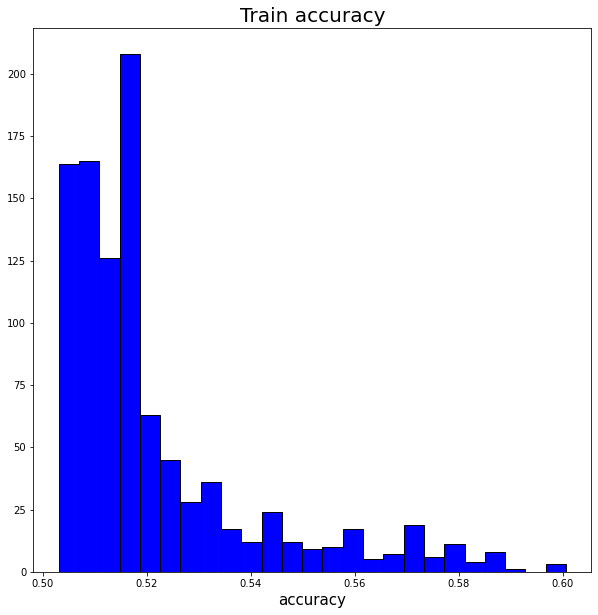

In [92]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [93]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.5214664634146342
0.018905221815223635


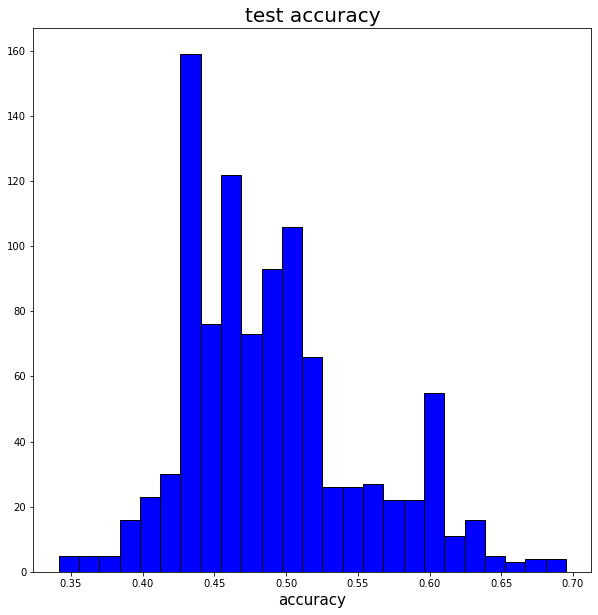

In [94]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [95]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.48990243902439035
0.06231983670069228


## ingredients_and_title

In [96]:
df['ingredients_and_title'] = df['meal_ingredients'].astype(str) +' '+ df['meal_title'].astype(str)

In [97]:
df['ingredients_and_title']

0      Mince meat 1/4 burger broccoli bean sprout Dinner
1      Slice Sausage quiche, mixed salad: lettuce, to...
2      Liverwurst/Gouda cheese sandwich lettuce tomat...
3                                     Chicken wing Wings
4      Salami/Swiss cheese wheat bread, trail mix: ca...
                             ...                        
405                           Egg white pepper Breakfast
406    1/2 cup oatmeal, 2x hard-boiled egg cup black ...
407    Yellow rice, black beans, mixed salad: lettuce...
408    Cup cashews, cup trail mix banana 23 oz bottle...
409    Jamaican vegetable pattie wheat 16 oz bottle w...
Name: ingredients_and_title, Length: 410, dtype: object

In [98]:
meal_ingredients_title = df.ingredients_and_title.apply(gensim.utils.simple_preprocess)

In [99]:
meal_ingredients_title

0      [mince, meat, burger, broccoli, bean, sprout, ...
1      [slice, sausage, quiche, mixed, salad, lettuce...
2      [liverwurst, gouda, cheese, sandwich, lettuce,...
3                                 [chicken, wing, wings]
4      [salami, swiss, cheese, wheat, bread, trail, m...
                             ...                        
405                      [egg, white, pepper, breakfast]
406    [cup, oatmeal, hard, boiled, egg, cup, black, ...
407    [yellow, rice, black, beans, mixed, salad, let...
408    [cup, cashews, cup, trail, mix, banana, oz, bo...
409    [jamaican, vegetable, pattie, wheat, oz, bottl...
Name: ingredients_and_title, Length: 410, dtype: object

In [100]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_ingredients_title, progress_per = 100)

embeddings.train(meal_ingredients_title, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_ingredients_title = embeddings.wv.index_to_key

In [101]:
learned_words_meal_ingredients_title

['oz',
 'and',
 'water',
 'chicken',
 'bottle',
 'rice',
 'of',
 'coffee',
 'salad',
 'black',
 'egg',
 'cheese',
 'milk',
 'bread',
 'eggs',
 'tomato',
 'cup',
 'pepper',
 'beans',
 'soup',
 'lettuce',
 'with',
 'sugar',
 'banana',
 'mixed',
 'garlic',
 'dash',
 'red',
 'pork',
 'sausage',
 'sandwich',
 'white',
 'onion',
 'powder',
 'boiled',
 'oatmeal',
 'dinner',
 'lunch',
 'mrs',
 'beef',
 'brown',
 'hard',
 'sweeter',
 'bran',
 'little',
 'oat',
 'onions',
 'wheat',
 'bit',
 'tsp',
 'yellow',
 'breakfast',
 'ham',
 'bean',
 'cinnamon',
 'steak',
 'broccoli',
 'carrots',
 'mayonnaise',
 'green',
 'cornflakes',
 'parsley',
 'tspn',
 'juice',
 'cilantro',
 'vegetable',
 'corn',
 'cracker',
 'orange',
 'fish',
 'cabbage',
 'slice',
 'roll',
 'breast',
 'noodle',
 'spaghetti',
 'crackers',
 'potato',
 'sauce',
 'fried',
 'raw',
 'string',
 'packs',
 'peppers',
 'meat',
 'tea',
 'cucumber',
 'spinach',
 'turkey',
 'french',
 'toast',
 'roast',
 'bacon',
 'strawberry',
 'carrot',
 'spic

In [102]:
words = []
for i in meal_ingredients_title:
    temp = []
    for j in i:
        if j in learned_words_meal_ingredients_title:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [103]:
l = []
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [104]:
data_y = np.squeeze(data_y)
data_y.shape

(410,)

In [105]:
data_X = pd.DataFrame(l)
data_X.shape

(410, 100)

In [106]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

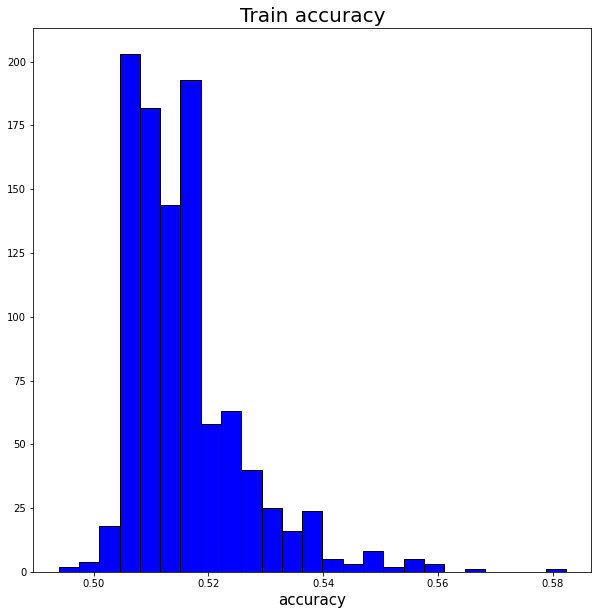

In [107]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [108]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.5154451219512195
0.010334261398646849


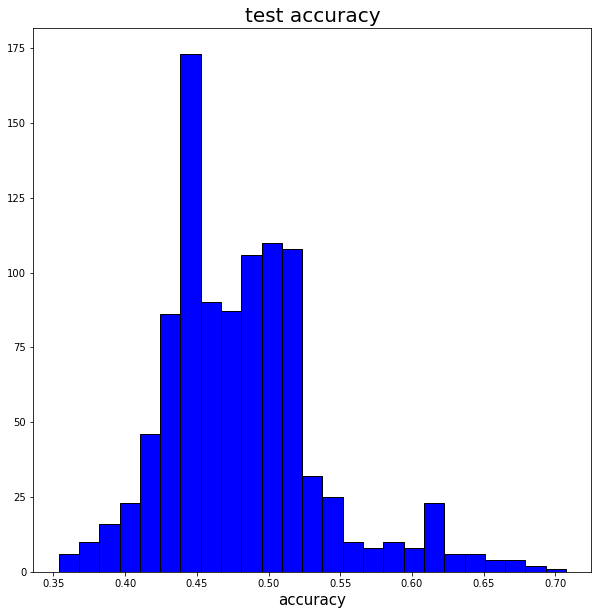

In [109]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [110]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.47969512195121955
0.05499009564166404
